<h1 id="tocheading">¿Vivir cerca de un Mcdonalds o un Hospital?</h1>


<div id="toc"></div>

En este jupyter intentaremos evaluar la relevancia que tienen las distancias a distintas localizaciones utilizando propiedades enlistadas para la venta en Houm.com. En particular las mas raras seran la distancia a un Mcdonalds y a un Starbucks

<img src=https://ia-latam.com/wp-content/uploads/2019/03/McDonalds-1170x500.jpg>


In [1]:
__author__ = 'cilopez'
# # Paquetes que se usaran en el notebook

# !pip3 install overpy
# !pip3 install pandas
# !pip3 install geopandas
# !pip3 install folium
# !pip3 install shap
# !pip3 install seaborn
# !pip3 install sklearn

In [2]:
import overpy
import numpy as np
import pandas as pd
import geopandas as gpd
import time
import seaborn as sns
import shap
from sklearn.neighbors import BallTree
from matplotlib import pyplot as plt
from folium import plugins, Map, Marker

## Carga de propiedades en venta

In [3]:
houm_dataframe = pd.read_csv('houm_dataframe.csv')
houm_dataframe.head()

,bedrooms,built_surface,bathrooms,latitude,longitude,parking,price
0,4,204,3,-33.363822,-70.496922,3,660000000
1,4,240,4,-33.377047,-70.525610,3,585000000
2,4,275,5,-33.398311,-70.588636,2,567000000
3,3,216,3,-33.367058,-70.495797,2,567000000
4,3,170,3,-33.366126,-70.520010,2,555000000


In [4]:
houm_dataframe.describe()

,bedrooms,built_surface,bathrooms,latitude,longitude,parking,price
count,490.000000,490.000000,490.000000,490.000000,490.000000,490.000000,4.900000e+02
mean,2.077551,61.840816,1.604082,-33.447165,-70.638863,0.724490,1.299577e+08
std,1.046030,41.965308,0.771676,0.036625,0.047564,0.883623,1.052636e+08
min,1.000000,17.000000,1.000000,-33.589044,-70.791875,0.000000,4.200000e+07
25%,1.000000,35.000000,1.000000,-33.457304,-70.664355,0.000000,6.600000e+07
50%,2.000000,47.000000,1.000000,-33.449352,-70.648401,1.000000,8.566500e+07
75%,3.000000,70.000000,2.000000,-33.429609,-70.609642,1.000000,1.492500e+08
max,8.000000,275.000000,5.000000,-33.334012,-70.495797,5.000000,6.600000e+08


### Histograma del precio de las propiedades enlistadas en houm.com

<AxesSubplot:>

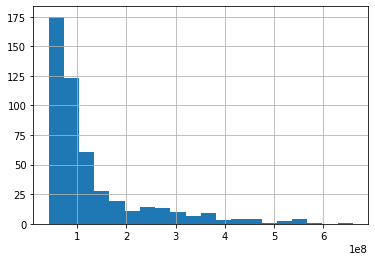

In [5]:
houm_dataframe.price.hist(bins=20)

In [6]:
houm_dataframe['latitude_rad'] = np.deg2rad(houm_dataframe['latitude'])
houm_dataframe['longitude_rad'] =  np.deg2rad(houm_dataframe['longitude'])

### Pin Map de propiedades enlistadas para la venta en Houm Octubre 2021

In [7]:
_map = Map(location=[houm_dataframe[['latitude']].mean(), houm_dataframe[['longitude']].mean()], zoom_start=12, control_scale=True)
for index, row in houm_dataframe.iterrows():
    Marker([row["latitude"], row["longitude"]],popup=row['price']).add_to(_map)
_map

## Extracción de datos desde Overpass (OSM)

Este es el formato con que se consulta información en Overpass, es un poco extraño pero despues de leer la wiki uno lo comprende

In [8]:
api = overpy.Overpass()

query = """
[out:json][timeout:25];
// gather results
(
  // query part for: “{0}={1}”
  node{2}["{0}"="{1}"]["name"](-33.65406616069705,-70.8343505859375,-33.29769836951746,-70.48416137695312);
  way["{0}"="{1}"](-33.65406616069705,-70.8343505859375,-33.29769836951746,-70.48416137695312);
  relation["{0}"="{1}"](-33.65406616069705,-70.8343505859375,-33.29769836951746,-70.48416137695312);
);
// print results
out center;
"""

In [9]:
def get_nodes(nodes,amenity_name):
    func_n = lambda x: [float(x.lat),float(x.lon),amenity_name,x.tags['name']]
    return [func_n(x) for x in nodes]

def get_ways(ways,amenity_name):
    output = list()
    for w in ways:
        lat = w.center_lat
        lon = w.center_lon
        if (w.center_lat == None) or (w.center_lon == None):
            lat = w.nodes[0].lat
            lon = w.nodes[0].lon
        if 'name' in w.tags:
            name = w.tags['name']
        else:
            name = 'NO NAME'
        output.append([float(lat),float(lon),amenity_name,name])
    return output

def results_to_list(result,amenity_name):
    return  get_nodes(result.nodes,amenity_name) + get_ways(result.ways,amenity_name)

Aca se define que tipo de localizaciones se van a consultar.

In [10]:
values = [
    {        
        'type':'amenity',
        'value':'hospital',
        'parameter': ''
    },
    {
        'type':'amenity',
        'value':'cafe',
        'parameter': '["brand:wikidata"="Q38076"]'
    },
    {
        'type':'amenity',
        'value':'fast_food',
        'parameter': '["brand:wikidata"="Q37158"]'
    },
    {
        'type':'amenity',
        'value':'police',
        'parameter': ''
    }
]

Se realiza la consulta localización por localizacion y se consolida en una lista. El time.sleep es porque a veces overpass se mofa con aquellos usuarios que hacen muchos requests

In [11]:
output = list()
for v in values:
    result = api.query(query.format(v['type'],v['value'],v['parameter']))
    output += results_to_list(result,v['value'])
    time.sleep(10)
print(len(output))    

388


Se genera el dataframe con las localizaciones de las areas de interés.

In [12]:
dataframe = pd.DataFrame(output, columns = ['latitude','longitude','type','name'])
dataframe['latitude_rad'] = np.deg2rad(dataframe['latitude'])
dataframe['longitude_rad'] =  np.deg2rad(dataframe['longitude'])

## Ball Trees y Mapas

In [13]:
def generate_heatmap(dataframe):
    gdf = gpd.GeoDataFrame(dataframe, geometry=gpd.points_from_xy(dataframe.longitude, dataframe.latitude))
    _map = Map(location = [-33.4617385885204, -70.6483346079144], tiles='Cartodb dark_matter', zoom_start = 11)
    heat_data = [[point.xy[1][0], point.xy[0][0]] for point in gdf.geometry ]
    plugins.HeatMap(heat_data).add_to(_map)
    return _map

Se generan a continuación los 4 ball trees por amenidad para poder obtener la distancia minima a la localización indicada.

In [14]:
df_police = dataframe[dataframe['type']=='police']
ball_police = BallTree(df_police[["latitude_rad", "longitude_rad"]].values, metric='haversine')

### Mapa localización de policías

In [15]:
generate_heatmap(df_police)

In [16]:
df_hospital = dataframe[dataframe['type']=='hospital']
ball_hospital = BallTree(df_hospital[["latitude_rad", "longitude_rad"]].values, metric='haversine')

### Mapa localización de hospitales

In [17]:
generate_heatmap(df_hospital)

In [18]:
df_mcdonald = dataframe[dataframe['type']=='fast_food']
ball_mcdonald = BallTree(df_mcdonald[["latitude_rad", "longitude_rad"]].values, metric='haversine')

### Mapa localización de Mcdonalds

In [19]:
generate_heatmap(df_mcdonald)

In [20]:
df_starbucks = dataframe[dataframe['type']=='cafe']
ball_starbucks = BallTree(df_starbucks[["latitude_rad", "longitude_rad"]].values, metric='haversine')

### Mapa localización de Starbucks

In [21]:
generate_heatmap(df_starbucks)

## Obtención de mínimas distancias

Del dataframe se obtiene el vecino más cercano (k=1) luego se multiplica la distancia por el radio de la tierra 6.371 kilómetros. Se generan cuatro columnas, una por cada localizacion a analizar.

In [22]:
distances, indices = ball_police.query(houm_dataframe[["latitude_rad", "longitude_rad"]].values, k = 1)
houm_dataframe['police_distance'] = distances*6371

In [23]:
distances, indices = ball_hospital.query(houm_dataframe[["latitude_rad", "longitude_rad"]].values, k = 1)
houm_dataframe['hospital_distance'] = distances*6371

In [24]:
distances, indices = ball_mcdonald.query(houm_dataframe[["latitude_rad", "longitude_rad"]].values, k = 1)
houm_dataframe['mcdonald_distance'] = distances*6371

In [25]:
distances, indices = ball_starbucks.query(houm_dataframe[["latitude_rad", "longitude_rad"]].values, k = 1)
houm_dataframe['starbucks_distance'] = distances*6371

## Modelo de predicción

Se genera la matriz X que permitirá predecir el vector y.

In [26]:
y = houm_dataframe[['price']]
houm_dataframe.drop(columns=['latitude','longitude','latitude_rad','longitude_rad','price'],inplace=True)
X = houm_dataframe

Se importa el modelo y se realiza la división entre traning set y test set

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.35, random_state = 1996)
model = RandomForestRegressor(min_samples_leaf=3,max_depth=4,criterion='mae')
model.fit(X_train,np.ravel(y_train))

RandomForestRegressor(criterion='mae', max_depth=4, min_samples_leaf=3)

Vector con las predicciones para training y test set

In [28]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

Visualización real v/s predicción. Lo ideal sería una linea recta.

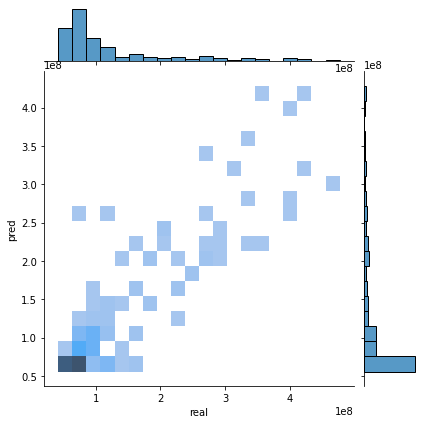

In [29]:
results = pd.DataFrame({'real':np.ravel(y_test.values),'pred':y_pred_test})
sns.jointplot(data=results, x="real", y="pred", kind="hist")

Error porcentual absoluto promedio de la predicción

In [30]:
mean_absolute_percentage_error(y_train, y_pred_train),mean_absolute_percentage_error(y_test, y_pred_test)

(0.15559540541185135, 0.18600547805481846)

## Relevancia de variables para la predicción

### Random Forest Feature Importance

La relevancia de variables de random forest nos permite sabe aquellas propiedades que permite separar de manera más efectiva registros "similares". De esta forma la superficie construida es claramente la que separa mejor propiedades similares, de todas formas la distancia a un Starbucks o a una estación de policía pareciera ser mas relevante que a un Mcdonald o a un hospital.

<BarContainer object of 8 artists>

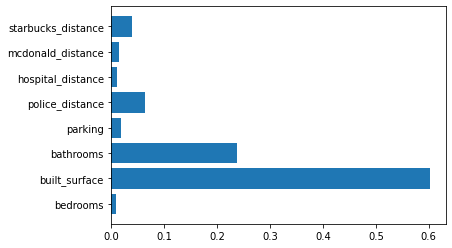

In [31]:
plt.barh(X.columns, model.feature_importances_)


Aunque este gráfico no nos permite saber si es que la relación es directa o inversa. ¿Es importante estar lejos de un starbucks o estar cerca?. Para responder esta pregunta utilizaremos la librería SHAP que permmite realizar un doble click a la relevancia de variables.

<BarContainer object of 4 artists>

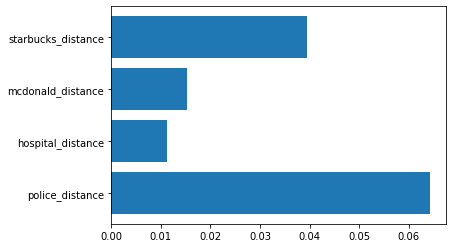

In [32]:
plt.barh(X.columns[4:], model.feature_importances_[4:])


### Shap Values


In [33]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap_obj = explainer(X_test)

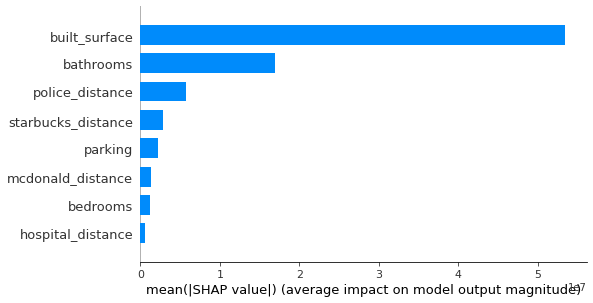

In [34]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

En este gráfico se ve la relación del valor de las propiedades con el impacto en el modelo. Aquellas que salen en rojo son con altos valores de la variable y en azul con bajos valores. En este caso el gráfico muestra que a altas distancias a estaciones de policías el valor de la propiedad aumenta. **¿Entonces es mejor vivir lejos de una comisaría?**

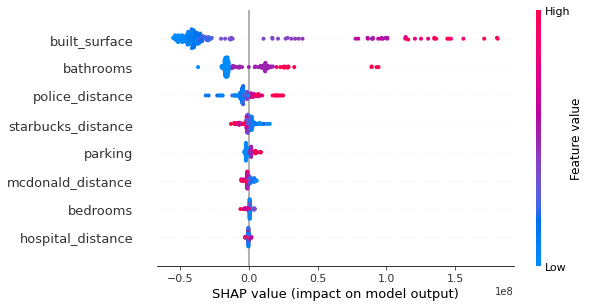

In [35]:
shap.plots.beeswarm(shap_obj, max_display=8)

Es raro que vivir lejos de la polícia sea algo bueno o suena algo contraintuitivo. Esta situación es típica en regresiones o en modelos de estimación, de hecho hay un artículo de esto bastante bueno  **"Oh no! I got th wrong sign ! What should i do?"**, en el documento se detallan escenarios típicos que generan esto:

- Mala teoría económica
- Variables omitidas
- Alta varianza
- Error de medida
- Sesgo de selección
- Outliers
- Confusión Ceteris paribus
- Otras

Quizás este pasando un poco de todo, el dataset esta relativamente sesgado a las propiedades que se enlistan en Houm ,las propiedades son relativamente distintas y tampoco es un conjunto muy grande de datos. Este tema puede dar para una tesis asi que no profundizaré y dejaré el código con dataset para que puedas realizar tus propios experimentos y conclusiones. Vivir cerca de un Mcdonald parece ser mas importante que un hospital o comisaría, ¿Es una conclusión apresurada? Sí.

In [36]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>